In [1]:
import pickle
import pandas as pd
import requests
from bs4 import BeautifulSoup
import sys
import os
from collections import defaultdict
import re
import json
from collections import Counter
import dateutil
from dateutil import parser
from collections import defaultdict
from __future__ import division
import datetime
%pylab inline
from numpy import arange
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
def parseint(string):
    string = str(string)
    return int(''.join([x for x in string if x.isdigit()]))

In [3]:
with open('movie_info_revised.p' ,'r') as picklefile:
    data = pickle.load(picklefile)

In [4]:
def date_helper(date):
    try:
        date = parser.parse(date)
        return True
    except: 
        pass
    return False

In [5]:
history_keys_dic = defaultdict(dict)
for key in data.keys():
    if 'Crime' in data[key]['genre'] and 'heist' in data[key]['keywords']:
        if date_helper(data[key]['date']):
            year = parser.parse(data[key]['date']).year
            history_keys_dic['count'][year]= history_keys_dic['count'].get(year, 0) + 1  
history_df = pd.DataFrame.from_dict(history_keys_dic)
start = pd.datetime(1980, 1, 1)
end = pd.datetime(2016, 1, 1)
x = pd.date_range(start, end, freq='A').year
history_df_years = history_df.reindex(x)
history_df = history_df_years.fillna(0)
history_df['rolling mean']=pd.rolling_mean(history_df['count'], 5).shift(+1)
history_df['difference from mean']=history_df['count']/history_df['rolling mean']

In [6]:
history_keys_dic

defaultdict(<type 'dict'>, {'count': {1972: 1, 1973: 3, 1974: 2, 1975: 1, 1978: 3, 1979: 2, 1981: 2, 1984: 2, 1985: 2, 1986: 1, 1987: 3, 1988: 1, 1989: 2, 1990: 2, 1991: 2, 1992: 2, 1993: 1, 1994: 2, 1995: 4, 1997: 3, 1998: 2, 1999: 6, 2000: 3, 2001: 10, 2002: 9, 2003: 9, 2004: 4, 2005: 2, 2006: 3, 2007: 3, 2008: 6, 2009: 4, 2010: 4, 2011: 4, 2012: 5, 2013: 4, 2014: 2, 2015: 4}})

In [7]:
history_df

,count,rolling mean,difference from mean
1980,0,NaN,NaN
1981,2,NaN,NaN
1982,0,NaN,NaN
1983,0,NaN,NaN
1984,2,NaN,NaN
1985,2,0.8,2.500000
1986,1,1.2,0.833333
1987,3,1.0,3.000000
1988,1,1.6,0.625000
1989,2,1.8,1.111111


In [8]:
history_dic = defaultdict(dict)
for key in data.keys():
    if 'Crime' in data[key]['genre'] and 'heist' in data[key]['keywords']:
        if date_helper(data[key]['date']):
            year = parser.parse(data[key]['date']).year
            history_dic[year][key]= defaultdict(dict)
            history_dic[year][key]['date']= data[key]['date']
            history_dic[year][key]['screens']= data[key]['screens']
            history_dic[year][key]['opening']= data[key]['opening']
                #space_dic['space'][year].append(key,)

In [9]:
history_dic

defaultdict(<type 'dict'>, {1972: {'The Getaway': defaultdict(<type 'dict'>, {'date': '13 December 1972', 'screens': 'n/a', 'opening': 'n/a'})}, 1973: {'Cops and Robbers': defaultdict(<type 'dict'>, {'date': '17 August 1973', 'screens': 'Error', 'opening': 'N/A'}), 'The Seven-Ups': defaultdict(<type 'dict'>, {'date': '14 December 1973', 'screens': 'Error', 'opening': 'N/A'}), 'The Sting': defaultdict(<type 'dict'>, {'date': '26 December 1973', 'screens': 'Error', 'opening': 'N/A'})}, 1974: {'Lady Ice': defaultdict(<type 'dict'>, {'date': '18 July 1974', 'screens': 'Error', 'opening': 'N/A'}), 'McQ': defaultdict(<type 'dict'>, {'date': '6 February 1974', 'screens': 'n/a', 'opening': 'n/a'})}, 1975: {'Dog Day Afternoon': defaultdict(<type 'dict'>, {'date': '21 September 1975', 'screens': 'n/a', 'opening': 'n/a'})}, 1978: {'Straight Time': defaultdict(<type 'dict'>, {'date': '14 July 1978', 'screens': 'Error', 'opening': 'N/A'}), 'Blue Collar': defaultdict(<type 'dict'>, {'date': '10 Febr

In [10]:
def makedf(genre):
    frames = []
    years = []
    for year, movies in genre.items():
        years.append(year)
        frames.append(pd.DataFrame.from_dict(movies, orient='index'))
    genre = pd.concat(frames, keys=years)
    genre = genre[genre.screens != 'N/A']
    genre = genre[genre.screens != 'n/a']
    genre = genre[genre.screens != 'Error']
    genre = genre[genre.opening != 'N/A']
    genre = genre[genre.screens != '']
    genre = genre[genre.opening != '']
    genre = genre[genre.opening != 'n/a']
    genre = genre[genre.opening != 'Error']
    genre['opening'] = genre['opening'].map(lambda x: parseint(x))
    genre['screens'] = genre['screens'].map(lambda x: parseint(x))
    genre['date'] = genre['date'].map(lambda x: parser.parse(x))
    genre['normalized_opening']= genre['opening']/genre['screens']
    genre = genre[genre.normalized_opening < 20000]
    return genre

In [11]:
genre=makedf(history_dic)
pd.set_option('display.max_rows', 1000)
genre1 = genre[genre.screens > 50]
genre1 = genre1.reset_index()
genre1

,level_0,level_1,date,screens,opening,normalized_opening
0,1979,The Great Train Robbery,1979-02-02,54,391942,7258.185185
1,1984,Once Upon a Time in America,1984-09-28,894,2412014,2698.002237
2,1984,The Pope of Greenwich Village,1984-06-22,677,1544624,2281.571640
3,1986,Armed and Dangerous,1986-08-15,1552,4348276,2801.724227
4,1987,Best Seller,1987-09-25,253,905399,3578.652174
5,1987,Beverly Hills Cop II,1987-05-20,2326,26348555,11327.839639
6,1987,Extreme Prejudice,1987-04-24,1071,3498957,3267.000000
7,1989,Family Business,1989-12-15,1201,2130024,1773.542048
8,1989,Renegades,1989-06-02,1627,3075030,1890.000000
9,1990,Quick Change,1990-07-13,1596,4700960,2945.463659


In [24]:
trend = genre1[25:42]
trend = trend[trend.screens > 2000]


#trend = trend[trend.screens > 1000]
trend

,level_0,level_1,date,screens,opening,normalized_opening
25,2001,3000 Miles to Graceland,2001-02-23,2545,7160521,2813.564244
26,2001,Bandits,2001-10-12,3207,13050700,4069.441846
28,2001,Ocean's Eleven,2001-12-07,3075,38107822,12392.787642
31,2001,Sugar Spice,2001-01-26,2150,5891176,2740.081860
32,2001,The Score,2001-07-13,2129,19018807,8933.211367
33,2002,Analyze That,2002-12-06,2635,11034422,4187.636433
35,2002,Hard Cash,2002-02-15,2459,7771753,3160.533957
37,2003,Bad Santa,2003-11-26,2005,12292952,6131.148130
38,2003,Cradle 2 the Grave,2003-02-28,2625,16521486,6293.899429
40,2003,The Italian Job,2003-05-30,2633,19457944,7390.028105


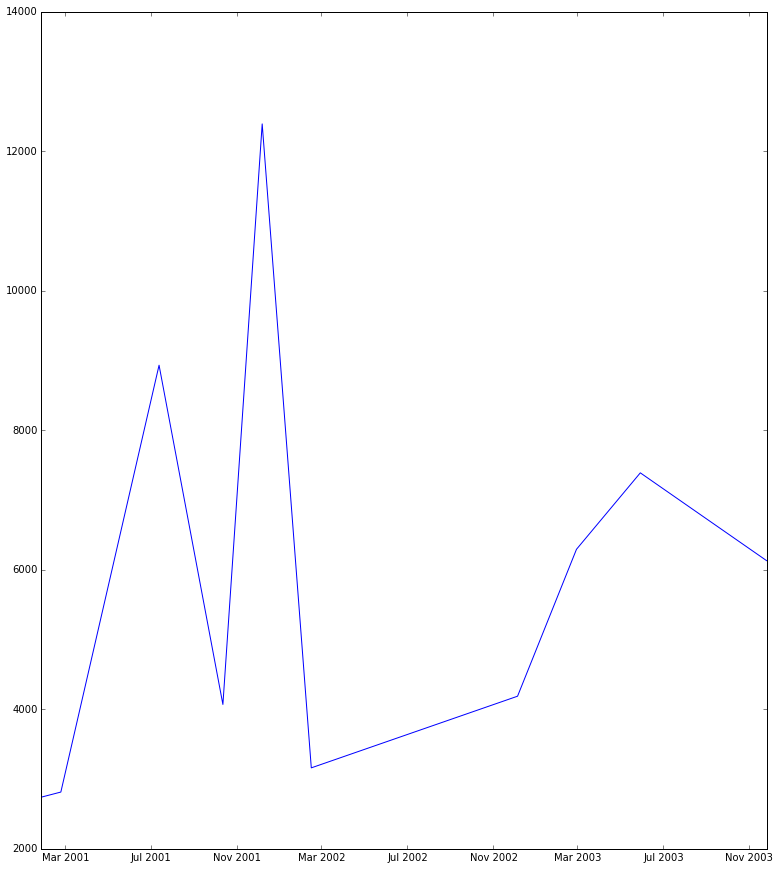

In [25]:
figure(figsize=(13,15))
trend = trend.sort(['date'])
plt.plot(trend['date'], trend['normalized_opening'])

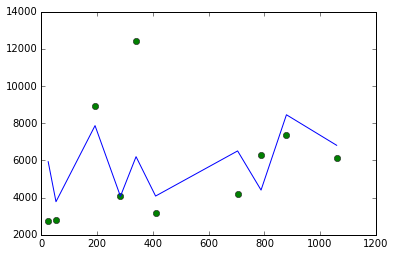

In [26]:
trend['time_delta']=trend['date'].apply(lambda x: str(x - parser.parse('2001-01-01')))
trend['time_delta_num'] = trend['time_delta'].str.replace(r'days[\s\S]+', '').apply(lambda x: int(x))

def sort_season(x):
    if x in [11, 12, 1]:
        return 'Winter'
    if x in [5, 6, 7, 8]:
        return 'Summer'
    if x in [9, 10,]:
        return 'Fall'
    if x in [2, 3, 4,]:
        return 'Spring'

trend['season']=trend['date'].apply(lambda x: sort_season(x.month))
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
#plot_data = trend
y, X = dmatrices('normalized_opening ~ time_delta_num + season ', data = trend, return_type= 'dataframe')
model = sm.OLS(y, X)
fitted = model.fit()
plot(X['time_delta_num'], y, 'go')
plot(X['time_delta_num'], fitted.fittedvalues, 'b')



In [15]:
model.fit().summary()

/Users/David/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1233: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     normalized_opening   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     2.948
Date:                Mon, 12 Oct 2015   Prob (F-statistic):             0.0654
Time:                        08:51:05   Log-Likelihood:                -156.45
No. Observations:                  17   AIC:                             322.9
Df Residuals:                      12   BIC:                             327.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept         2174.2717   2322.491      0.936      0.368     -2886.002  7234.545
season[T.Spring]  1230.3415   2364.576      0.520      0.612     -3921.627  6382.310
season[T.Summer]  7348.2438   2382.938      3.084      0.009      2156.269  1.25e+04
season[T.Winter]  3205.0409   2087.683      1.535      0.151     -1343.629  7753.711
time_delta_num       0.0261      2.124      0.012      0.990        -4.602     4.654
==============================================================================
Omnibus:                       11.090   Durbin-Watson:                   2.459
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                7.821
Skew:                           1.405   Prob(JB):                       0.0200
Kurtosis:                       4.773   Cond. No.                     3.51e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
trend = trend.reset_index()
with open('heist_df.p', 'w') as picklefile:
    pickle.dump(trend, picklefile)